# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import warnings

% matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
# sort dfdata based on longitude
dfdata = dfdata.sort_values("longitude")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
5962,-180,38,4,-5425.0,NaN,5.702333,NaN,427.678925,34.342628,NaN,15.691460
5757,-180,39,4,-5335.0,NaN,5.829761,NaN,497.673096,34.254448,NaN,14.695810
32077,-180,-55,4,-5287.0,NaN,6.456027,NaN,335.052032,34.125984,NaN,6.751073
5562,-180,40,4,-5241.0,NaN,5.968406,NaN,584.339844,34.158997,NaN,13.663589


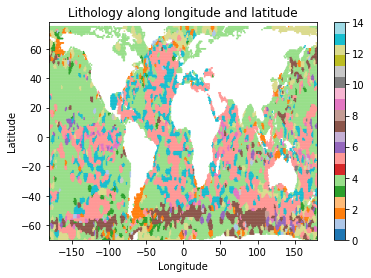

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = pl.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    pl.title(title)
    pl.xlim([-180, 180])
    pl.ylim([-70, 78])
    pl.xlabel("Longitude")
    pl.ylabel("Latitude")
    pl.colorbar(sc)
    pl.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

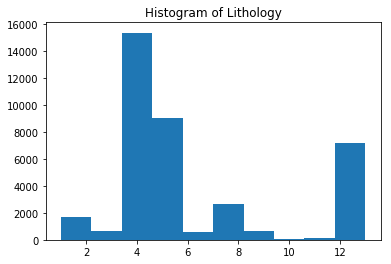

In [3]:
def draw_hist(y, title):
    # plot the histogram of lithology
    pl.hist(y)
    pl.title(title)
    pl.show()

draw_hist(y, "Histogram of Lithology")

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.

In [4]:
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, Model
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
warnings.simplefilter("ignore")

Using Theano backend.


### Data preprocessing
* Normalize features X
* Onehot multiclass target Y

In [5]:
# obtain list of feature names
training_data = dfdata.copy()
target = "lithology"
features = list(training_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# extract X and Y
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

### Construct neural network
The neural network has the following structure:
- Input layer
- Hidden layer 1: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 2: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 3: consists of 32 nerons
- Output layer

In [6]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# parameters for hidden layers
activation = "relu"
dropout_ratio = 0.1
initializer = "random_uniform"
dropout_ratio = 0.2
numclass = dummy_Y.shape[1]
N, d = X.shape

# construct layers
inputs = Input(shape=(d,))
layer = Dense(64, activation=activation, kernel_initializer=initializer)(inputs)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(64, activation=activation, kernel_initializer=initializer)(layer)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(32, activation=activation, kernel_initializer=initializer)(layer)
prediction = Dense(numclass, activation="softmax")(layer)

# create model
model = Model(inputs=inputs, outputs=prediction)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 13)                429       
Total para

Train on 24351 samples, validate on 6088 samples
Epoch 1/200
24351/24351 [==============================] - 2s 94us/step - loss: 1.4899 - acc: 0.4603 - val_loss: 1.6744 - val_acc: 0.4634
Epoch 2/200
24351/24351 [==============================] - 2s 96us/step - loss: 1.3896 - acc: 0.5012 - val_loss: 1.6831 - val_acc: 0.4759
Epoch 3/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.3648 - acc: 0.5113 - val_loss: 1.6878 - val_acc: 0.4790
Epoch 4/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.3475 - acc: 0.5168 - val_loss: 1.6382 - val_acc: 0.4780
Epoch 5/200
24351/24351 [==============================] - 2s 96us/step - loss: 1.3299 - acc: 0.5214 - val_loss: 1.5969 - val_acc: 0.4857
Epoch 6/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.3157 - acc: 0.5264 - val_loss: 1.6120 - val_acc: 0.4759
Epoch 7/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.3072 - acc: 0.5261 - val_loss: 1.6128 - v

24351/24351 [==============================] - 2s 99us/step - loss: 1.1653 - acc: 0.5732 - val_loss: 1.7413 - val_acc: 0.4737
Epoch 60/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.1592 - acc: 0.5709 - val_loss: 1.7450 - val_acc: 0.4691
Epoch 61/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1674 - acc: 0.5692 - val_loss: 1.8052 - val_acc: 0.4630
Epoch 62/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1608 - acc: 0.5683 - val_loss: 1.7628 - val_acc: 0.4683
Epoch 63/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.1603 - acc: 0.5691 - val_loss: 1.7922 - val_acc: 0.4639
Epoch 64/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1605 - acc: 0.5712 - val_loss: 1.8090 - val_acc: 0.4639
Epoch 65/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1601 - acc: 0.5697 - val_loss: 1.7514 - val_acc: 0.4647
Epoch 66/200
24351/24351 [==============

Epoch 118/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.1399 - acc: 0.5757 - val_loss: 1.7547 - val_acc: 0.4663
Epoch 119/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1371 - acc: 0.5826 - val_loss: 1.8147 - val_acc: 0.4491
Epoch 120/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1368 - acc: 0.5808 - val_loss: 1.7692 - val_acc: 0.4606
Epoch 121/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.1404 - acc: 0.5781 - val_loss: 1.7631 - val_acc: 0.4625
Epoch 122/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1334 - acc: 0.5799 - val_loss: 1.8078 - val_acc: 0.4609
Epoch 123/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.1446 - acc: 0.5800 - val_loss: 1.8060 - val_acc: 0.4599
Epoch 124/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.1384 - acc: 0.5773 - val_loss: 1.7686 - val_acc: 0.4634
Epoch 125/200
24351/

24351/24351 [==============================] - 2s 97us/step - loss: 1.1291 - acc: 0.5844 - val_loss: 1.8538 - val_acc: 0.4637
Epoch 177/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.1269 - acc: 0.5799 - val_loss: 1.8554 - val_acc: 0.4514
Epoch 178/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.1281 - acc: 0.5820 - val_loss: 1.8710 - val_acc: 0.4515
Epoch 179/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.1224 - acc: 0.5819 - val_loss: 1.8530 - val_acc: 0.4570
Epoch 180/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.1241 - acc: 0.5845 - val_loss: 1.8459 - val_acc: 0.4419
Epoch 181/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.1222 - acc: 0.5851 - val_loss: 1.9100 - val_acc: 0.4476
Epoch 182/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.1233 - acc: 0.5837 - val_loss: 1.8910 - val_acc: 0.4272
Epoch 183/200
24351/24351 [=======

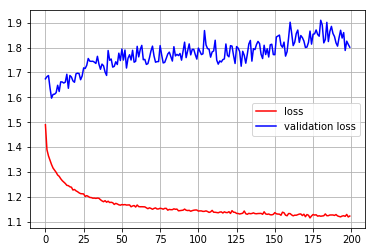

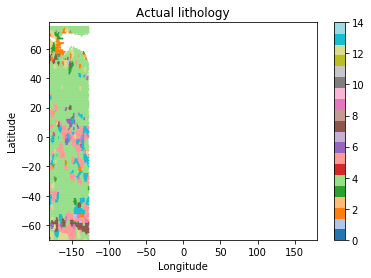

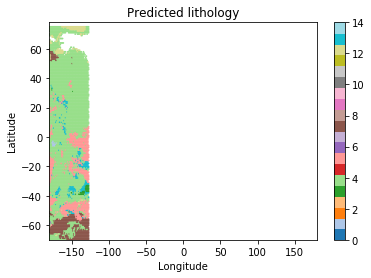

Train on 24351 samples, validate on 6088 samples
Epoch 1/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.2140 - acc: 0.5802 - val_loss: 1.7065 - val_acc: 0.4607
Epoch 2/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1804 - acc: 0.5842 - val_loss: 1.7288 - val_acc: 0.4681
Epoch 3/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1606 - acc: 0.5903 - val_loss: 1.7215 - val_acc: 0.4755
Epoch 4/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1627 - acc: 0.5891 - val_loss: 1.6878 - val_acc: 0.4575
Epoch 5/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.1524 - acc: 0.5926 - val_loss: 1.7156 - val_acc: 0.4675
Epoch 6/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1490 - acc: 0.5935 - val_loss: 1.7707 - val_acc: 0.4642
Epoch 7/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1416 - acc: 0.5955 - val_loss: 1.7584 - v

24351/24351 [==============================] - 2s 101us/step - loss: 1.0867 - acc: 0.6110 - val_loss: 1.7755 - val_acc: 0.4644
Epoch 60/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.0847 - acc: 0.6086 - val_loss: 1.8398 - val_acc: 0.4530
Epoch 61/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.0902 - acc: 0.6105 - val_loss: 1.8393 - val_acc: 0.4547
Epoch 62/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0908 - acc: 0.6104 - val_loss: 1.7701 - val_acc: 0.4782
Epoch 63/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0911 - acc: 0.6130 - val_loss: 1.7629 - val_acc: 0.4553
Epoch 64/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0829 - acc: 0.6088 - val_loss: 1.8950 - val_acc: 0.4420
Epoch 65/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0893 - acc: 0.6072 - val_loss: 1.7795 - val_acc: 0.4616
Epoch 66/200
24351/24351 [=======

24351/24351 [==============================] - 2s 101us/step - loss: 1.0671 - acc: 0.6173 - val_loss: 1.8936 - val_acc: 0.4425
Epoch 118/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0743 - acc: 0.6145 - val_loss: 1.8966 - val_acc: 0.4473
Epoch 119/200
24351/24351 [==============================] - 3s 104us/step - loss: 1.0747 - acc: 0.6137 - val_loss: 1.8948 - val_acc: 0.4446
Epoch 120/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.0756 - acc: 0.6143 - val_loss: 1.8285 - val_acc: 0.4614
Epoch 121/200
24351/24351 [==============================] - 2s 102us/step - loss: 1.0702 - acc: 0.6107 - val_loss: 1.8662 - val_acc: 0.4558
Epoch 122/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.0724 - acc: 0.6146 - val_loss: 1.8343 - val_acc: 0.4680
Epoch 123/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0768 - acc: 0.6123 - val_loss: 1.9102 - val_acc: 0.4593
Epoch 124/200
24351/24351 [

24351/24351 [==============================] - 2s 98us/step - loss: 1.0649 - acc: 0.6162 - val_loss: 1.9138 - val_acc: 0.4596
Epoch 176/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.0681 - acc: 0.6168 - val_loss: 1.8951 - val_acc: 0.4488
Epoch 177/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.0671 - acc: 0.6189 - val_loss: 1.8980 - val_acc: 0.4389
Epoch 178/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0623 - acc: 0.6191 - val_loss: 1.9649 - val_acc: 0.4304
Epoch 179/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.0713 - acc: 0.6151 - val_loss: 1.8941 - val_acc: 0.4419
Epoch 180/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.0655 - acc: 0.6171 - val_loss: 1.8669 - val_acc: 0.4343
Epoch 181/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.0647 - acc: 0.6167 - val_loss: 1.8948 - val_acc: 0.4302
Epoch 182/200
24351/24351 [=======

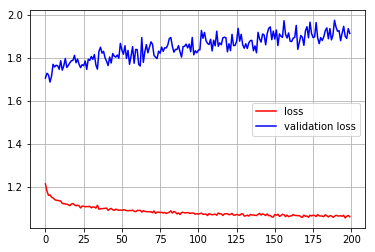

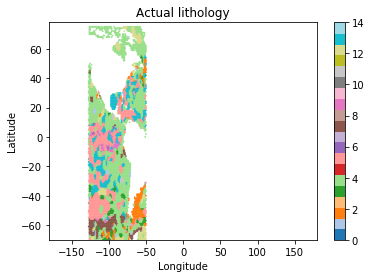

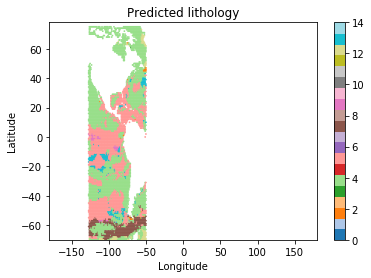

Train on 24351 samples, validate on 6088 samples
Epoch 1/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.2080 - acc: 0.5818 - val_loss: 1.7967 - val_acc: 0.4377
Epoch 2/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1709 - acc: 0.5878 - val_loss: 1.8213 - val_acc: 0.4453
Epoch 3/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.1621 - acc: 0.5908 - val_loss: 1.8415 - val_acc: 0.4524
Epoch 4/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.1571 - acc: 0.5951 - val_loss: 1.8096 - val_acc: 0.4455
Epoch 5/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1476 - acc: 0.5962 - val_loss: 1.8100 - val_acc: 0.4394
Epoch 6/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.1417 - acc: 0.5974 - val_loss: 1.8600 - val_acc: 0.4435
Epoch 7/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.1290 - acc: 0.5989 - val_loss: 1.8621 - 

24351/24351 [==============================] - 2s 99us/step - loss: 1.0989 - acc: 0.6122 - val_loss: 1.8192 - val_acc: 0.4778
Epoch 60/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0915 - acc: 0.6126 - val_loss: 1.8006 - val_acc: 0.4668
Epoch 61/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0892 - acc: 0.6160 - val_loss: 1.8820 - val_acc: 0.4492
Epoch 62/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0921 - acc: 0.6111 - val_loss: 1.8540 - val_acc: 0.4598
Epoch 63/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0875 - acc: 0.6165 - val_loss: 1.8713 - val_acc: 0.4601
Epoch 64/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.0845 - acc: 0.6169 - val_loss: 1.8217 - val_acc: 0.4599
Epoch 65/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0916 - acc: 0.6141 - val_loss: 1.9054 - val_acc: 0.4446
Epoch 66/200
24351/24351 [==============

Epoch 118/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0797 - acc: 0.6166 - val_loss: 1.8792 - val_acc: 0.4391
Epoch 119/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0745 - acc: 0.6190 - val_loss: 1.8826 - val_acc: 0.4630
Epoch 120/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0750 - acc: 0.6205 - val_loss: 1.9577 - val_acc: 0.4427
Epoch 121/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0701 - acc: 0.6189 - val_loss: 1.9357 - val_acc: 0.4433
Epoch 122/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0774 - acc: 0.6186 - val_loss: 1.9065 - val_acc: 0.4504
Epoch 123/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0717 - acc: 0.6166 - val_loss: 1.9087 - val_acc: 0.4598
Epoch 124/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0794 - acc: 0.6202 - val_loss: 1.8584 - val_acc: 0.4527
Epoch 125/200
24351

24351/24351 [==============================] - 2s 100us/step - loss: 1.0642 - acc: 0.6210 - val_loss: 1.9321 - val_acc: 0.4486
Epoch 177/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0694 - acc: 0.6199 - val_loss: 1.9408 - val_acc: 0.4481
Epoch 178/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0640 - acc: 0.6210 - val_loss: 1.9550 - val_acc: 0.4571
Epoch 179/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0635 - acc: 0.6188 - val_loss: 1.9173 - val_acc: 0.4545
Epoch 180/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0640 - acc: 0.6224 - val_loss: 1.9510 - val_acc: 0.4446
Epoch 181/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0718 - acc: 0.6167 - val_loss: 1.9132 - val_acc: 0.4466
Epoch 182/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0707 - acc: 0.6205 - val_loss: 1.9470 - val_acc: 0.4540
Epoch 183/200
24351/24351 [

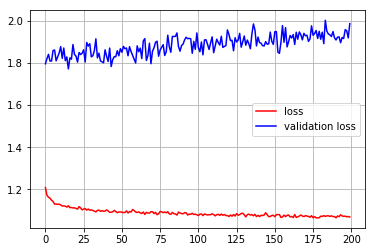

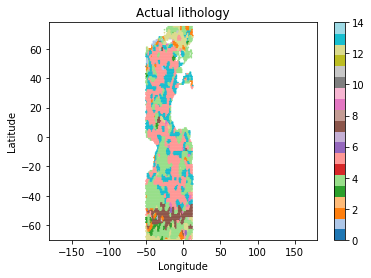

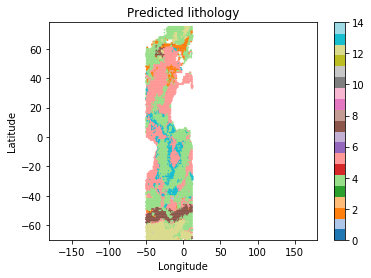

Train on 24351 samples, validate on 6088 samples
Epoch 1/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.1722 - acc: 0.5820 - val_loss: 1.8598 - val_acc: 0.4745
Epoch 2/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.1466 - acc: 0.5851 - val_loss: 1.8019 - val_acc: 0.4732
Epoch 3/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.1354 - acc: 0.5956 - val_loss: 1.8499 - val_acc: 0.4783
Epoch 4/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.1222 - acc: 0.5973 - val_loss: 1.8591 - val_acc: 0.4535
Epoch 5/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.1212 - acc: 0.5954 - val_loss: 1.8198 - val_acc: 0.4690
Epoch 6/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.1132 - acc: 0.5967 - val_loss: 1.9070 - val_acc: 0.4534
Epoch 7/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.1128 - acc: 0.6005 - val_loss: 1.8

24351/24351 [==============================] - 2s 101us/step - loss: 1.0726 - acc: 0.6130 - val_loss: 1.8604 - val_acc: 0.4714
Epoch 60/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.0727 - acc: 0.6138 - val_loss: 1.8333 - val_acc: 0.4808
Epoch 61/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.0799 - acc: 0.6111 - val_loss: 1.8557 - val_acc: 0.4668
Epoch 62/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.0599 - acc: 0.6166 - val_loss: 1.8864 - val_acc: 0.4455
Epoch 63/200
24351/24351 [==============================] - 2s 102us/step - loss: 1.0779 - acc: 0.6148 - val_loss: 1.8724 - val_acc: 0.4874
Epoch 64/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0721 - acc: 0.6173 - val_loss: 1.8166 - val_acc: 0.4653
Epoch 65/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0753 - acc: 0.6165 - val_loss: 1.8132 - val_acc: 0.4717
Epoch 66/200
24351/24351 [=======

24351/24351 [==============================] - 2s 101us/step - loss: 1.0631 - acc: 0.6180 - val_loss: 1.9119 - val_acc: 0.4644
Epoch 118/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.0658 - acc: 0.6161 - val_loss: 1.9101 - val_acc: 0.4537
Epoch 119/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.0608 - acc: 0.6186 - val_loss: 1.9482 - val_acc: 0.4460
Epoch 120/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.0576 - acc: 0.6208 - val_loss: 1.9634 - val_acc: 0.4460
Epoch 121/200
24351/24351 [==============================] - 2s 102us/step - loss: 1.0644 - acc: 0.6188 - val_loss: 1.9294 - val_acc: 0.4647
Epoch 122/200
24351/24351 [==============================] - 2s 101us/step - loss: 1.0651 - acc: 0.6158 - val_loss: 1.9009 - val_acc: 0.4583
Epoch 123/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0720 - acc: 0.6160 - val_loss: 1.9206 - val_acc: 0.4492
Epoch 124/200
24351/24351 [

24351/24351 [==============================] - 2s 100us/step - loss: 1.0572 - acc: 0.6202 - val_loss: 1.9765 - val_acc: 0.4415
Epoch 176/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0581 - acc: 0.6184 - val_loss: 1.9916 - val_acc: 0.4277
Epoch 177/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0551 - acc: 0.6199 - val_loss: 1.9968 - val_acc: 0.4386
Epoch 178/200
24351/24351 [==============================] - 2s 100us/step - loss: 1.0621 - acc: 0.6202 - val_loss: 1.9958 - val_acc: 0.4494
Epoch 179/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0573 - acc: 0.6206 - val_loss: 1.9973 - val_acc: 0.4566
Epoch 180/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0557 - acc: 0.6243 - val_loss: 1.9604 - val_acc: 0.4397
Epoch 181/200
24351/24351 [==============================] - 2s 99us/step - loss: 1.0579 - acc: 0.6222 - val_loss: 2.0130 - val_acc: 0.4336
Epoch 182/200
24351/24351 [===

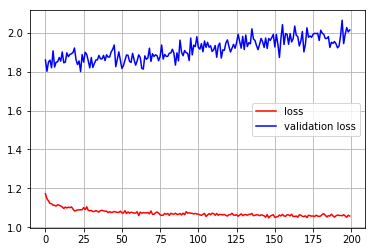

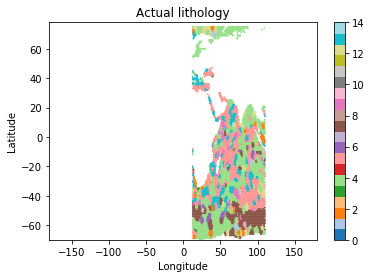

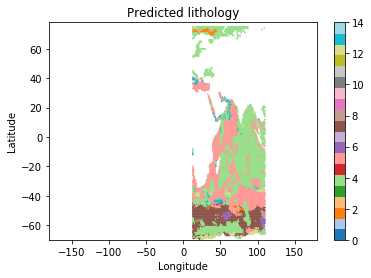

Train on 24352 samples, validate on 6088 samples
Epoch 1/200
24352/24352 [==============================] - 2s 100us/step - loss: 1.0890 - acc: 0.6181 - val_loss: 1.5320 - val_acc: 0.4869
Epoch 2/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0867 - acc: 0.6173 - val_loss: 1.5518 - val_acc: 0.4670
Epoch 3/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0740 - acc: 0.6169 - val_loss: 1.5481 - val_acc: 0.4602
Epoch 4/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0712 - acc: 0.6202 - val_loss: 1.4979 - val_acc: 0.4847
Epoch 5/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0673 - acc: 0.6204 - val_loss: 1.5452 - val_acc: 0.4576
Epoch 6/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0635 - acc: 0.6219 - val_loss: 1.5037 - val_acc: 0.4653
Epoch 7/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0611 - acc: 0.6195 - val_loss: 1.5

24352/24352 [==============================] - 2s 101us/step - loss: 1.0433 - acc: 0.6269 - val_loss: 1.5719 - val_acc: 0.4437
Epoch 60/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0355 - acc: 0.6229 - val_loss: 1.5669 - val_acc: 0.4558
Epoch 61/200
24352/24352 [==============================] - 2s 102us/step - loss: 1.0495 - acc: 0.6197 - val_loss: 1.5731 - val_acc: 0.4525
Epoch 62/200
24352/24352 [==============================] - 2s 102us/step - loss: 1.0365 - acc: 0.6238 - val_loss: 1.5746 - val_acc: 0.4499
Epoch 63/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0354 - acc: 0.6248 - val_loss: 1.5779 - val_acc: 0.4652
Epoch 64/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0415 - acc: 0.6234 - val_loss: 1.5829 - val_acc: 0.4527
Epoch 65/200
24352/24352 [==============================] - 2s 102us/step - loss: 1.0423 - acc: 0.6236 - val_loss: 1.5604 - val_acc: 0.4519
Epoch 66/200
24352/24352 [=======

24352/24352 [==============================] - 2s 101us/step - loss: 1.0347 - acc: 0.6263 - val_loss: 1.5846 - val_acc: 0.4612
Epoch 118/200
24352/24352 [==============================] - 2s 100us/step - loss: 1.0356 - acc: 0.6259 - val_loss: 1.6042 - val_acc: 0.4474
Epoch 119/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0381 - acc: 0.6272 - val_loss: 1.5796 - val_acc: 0.4576
Epoch 120/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0362 - acc: 0.6237 - val_loss: 1.5807 - val_acc: 0.4571
Epoch 121/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0381 - acc: 0.6262 - val_loss: 1.6038 - val_acc: 0.4428
Epoch 122/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0399 - acc: 0.6275 - val_loss: 1.6258 - val_acc: 0.4502
Epoch 123/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0397 - acc: 0.6274 - val_loss: 1.6285 - val_acc: 0.4483
Epoch 124/200
24352/24352 [

24352/24352 [==============================] - 2s 101us/step - loss: 1.0416 - acc: 0.6282 - val_loss: 1.6125 - val_acc: 0.4389
Epoch 176/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0425 - acc: 0.6257 - val_loss: 1.5813 - val_acc: 0.4453
Epoch 177/200
24352/24352 [==============================] - 2s 102us/step - loss: 1.0387 - acc: 0.6263 - val_loss: 1.6099 - val_acc: 0.4506
Epoch 178/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0430 - acc: 0.6241 - val_loss: 1.5897 - val_acc: 0.4446
Epoch 179/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0348 - acc: 0.6259 - val_loss: 1.6143 - val_acc: 0.4509
Epoch 180/200
24352/24352 [==============================] - 2s 101us/step - loss: 1.0383 - acc: 0.6289 - val_loss: 1.6057 - val_acc: 0.4538
Epoch 181/200
24352/24352 [==============================] - 2s 102us/step - loss: 1.0470 - acc: 0.6225 - val_loss: 1.5930 - val_acc: 0.4400
Epoch 182/200
24352/24352 [

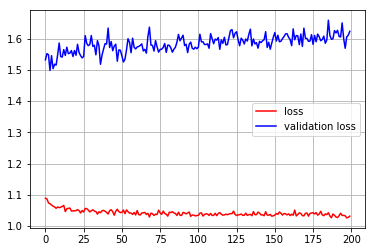

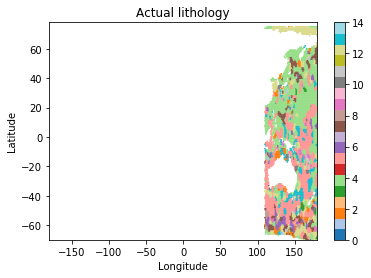

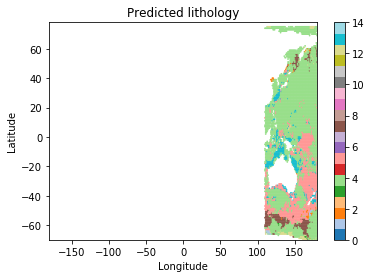

In [7]:
# parameters for training
epochs = 200
batch_size = 5
verbose = True

# use 5 fold cross validation without shuffle
kfold = KFold(n_splits=5, random_state=seed)
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values

# training
prediction = np.zeros((N, numclass))
for train_ind, test_ind in kfold.split(X):
    train_X, train_Y = X[train_ind], dummy_Y[train_ind]
    # record loss in training and validation
    history = History()
    model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=weight,
              validation_split=0.2, shuffle=True, callbacks=[history])
    # plot loss versus epochs
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    pl.plot(history.epoch, loss, "r-", label="loss")
    pl.plot(history.epoch, val_loss, "b-", label="validation loss")
    pl.grid()
    pl.legend()
    pl.show()
    # predict and draw scatterplot for prediction set
    mu = model.predict(X[test_ind])
    prediction[test_ind, :] = mu
    mean = np.argmax(mu, axis=1)
    draw_global(lon[test_ind], lat[test_ind], Y[test_ind] + 1, "Actual lithology")
    draw_global(lon[test_ind], lat[test_ind], mean + 1, "Predicted lithology")

### Validate

Accuracy = 0.46931588215196196


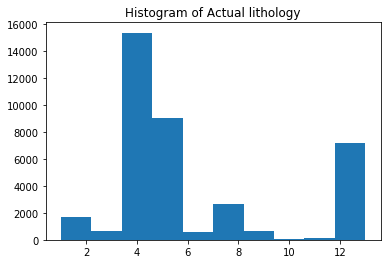

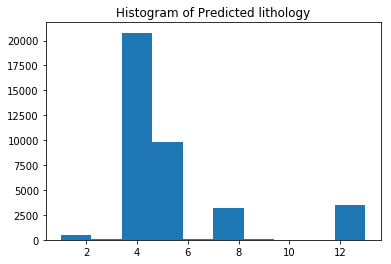

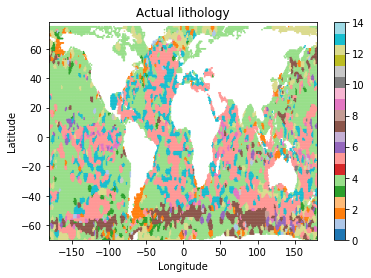

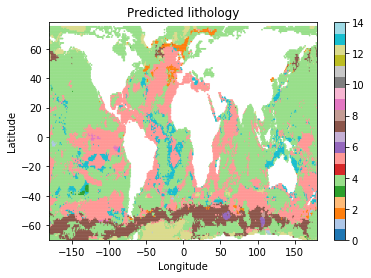

In [8]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values

mean = np.argmax(prediction, axis=1)
print("Accuracy = {}".format(accuracy_score(Y, mean)))
draw_hist(Y + 1, "Histogram of Actual lithology")
draw_hist(mean + 1, "Histogram of Predicted lithology")
draw_global(lon, lat, Y + 1, "Actual lithology")
draw_global(lon, lat, mean + 1, "Predicted lithology")

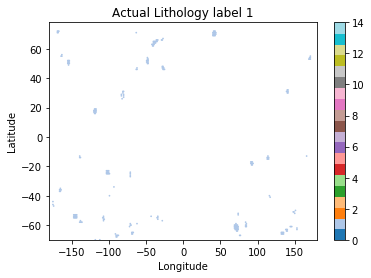

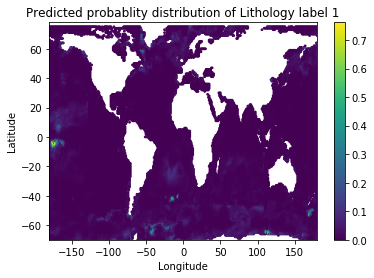

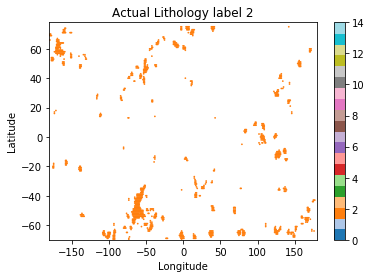

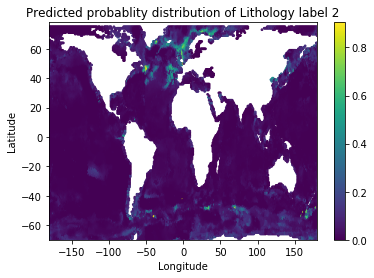

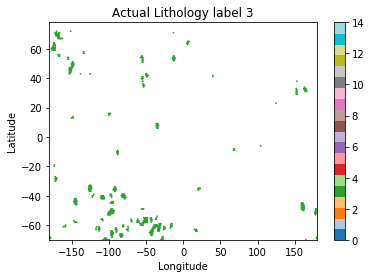

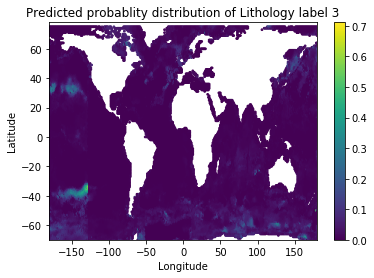

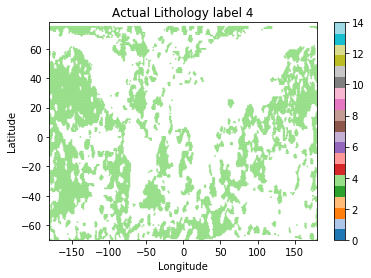

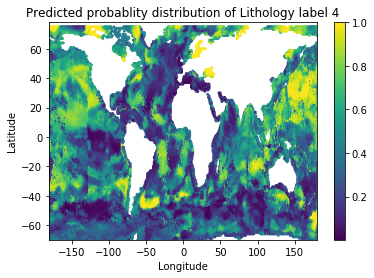

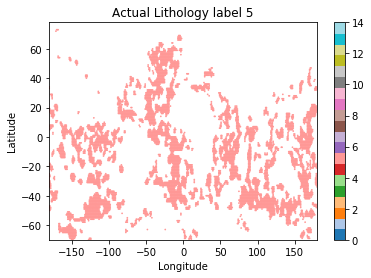

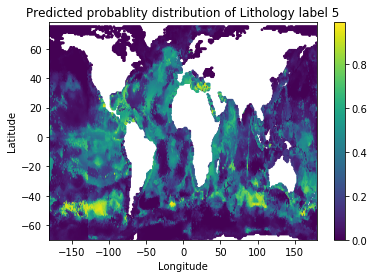

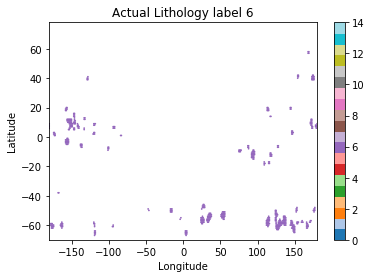

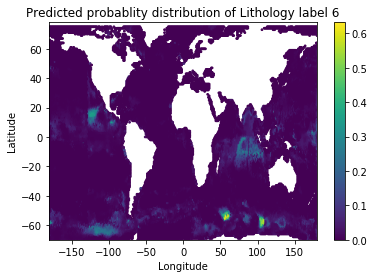

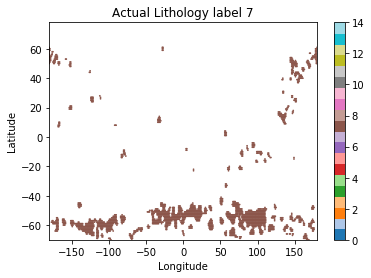

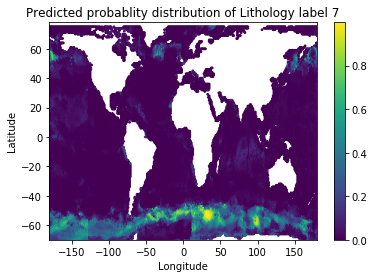

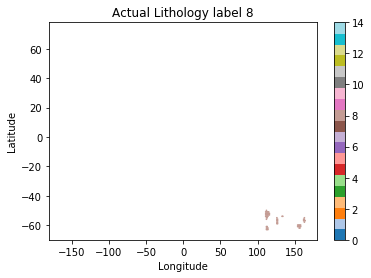

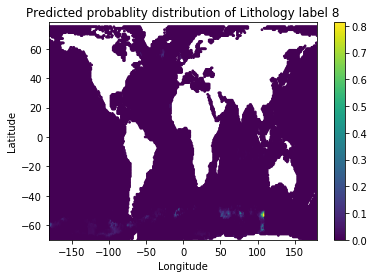

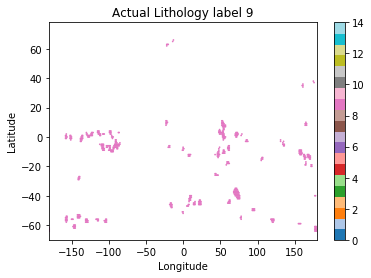

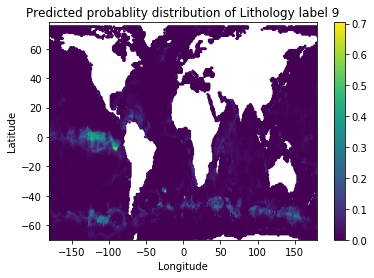

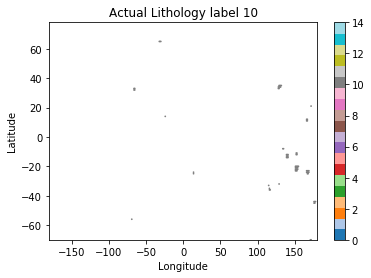

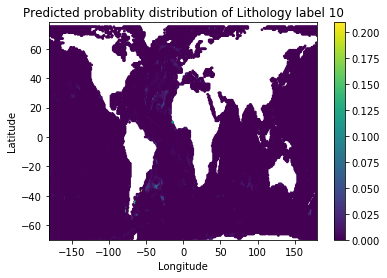

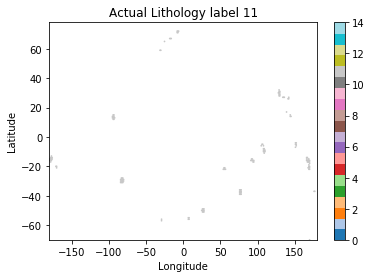

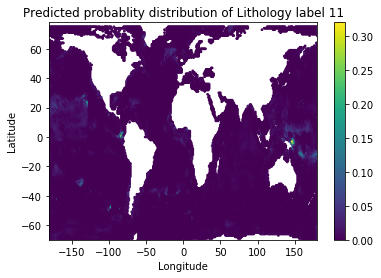

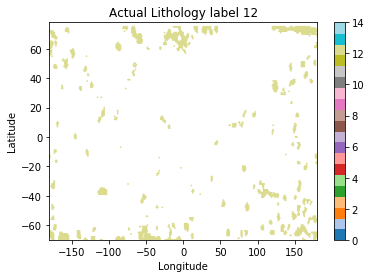

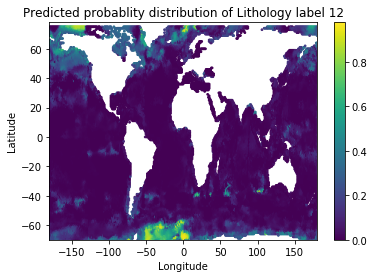

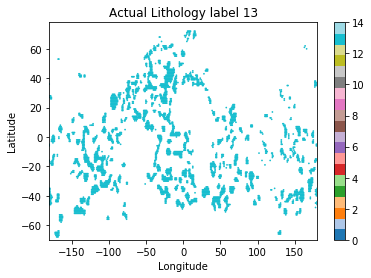

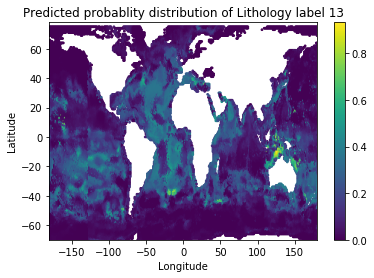

In [9]:
def draw_prob(lon, lat, p, title, size=3):
    sc = pl.scatter(lon, lat, s=size, c=p)
    pl.title(title)
    pl.xlim([-180, 180])
    pl.ylim([-70, 78])
    pl.xlabel("Longitude")
    pl.ylabel("Latitude")
    pl.colorbar(sc)
    pl.show()
    pl.close()
    
for i in range(13):
    common_part = "Lithology label {}".format(i + 1)
    title_p = "Predicted probablity distribution of {}".format(common_part)
    title_y = "Actual {}".format(common_part)
    # find Y_ts whose label is i + 1 and plot
    index = Y == i
    thisY = Y[Y == i] + 1
    draw_global(lon[index], lat[index], y=thisY, title=title_y)
    # plot prob distribution
    draw_prob(lon, lat, p = prediction[:,i], title=title_p)